### Import

In [ ]:
import pandas as pd
import json
import yaml
import shutil
from ultralytics import YOLO
from pathlib import Path

In [3]:
DATASET_YAML = Path("../data/silver/")  # point to your dataset.yaml
BASE_MODEL = "yolov8n-cls.pt"
EPOCHS = 50
IMG_SIZE = 512
FRACTION = 1
BATCH = 16
DEVICE = "cpu"
PROJECT_PATH = Path("../runs/classify")

CLASSES = {
    "pizza": 76,
    "spaghetti_bolognese": 90,
    "spaghetti_carbonara": 91,
}

### Gather statistics of model training runs

In [4]:
rows = []
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols: return c
    return None
for run in sorted(PROJECT_PATH.glob("food101_e*_img*_frac*")):
    args_p     = run / "args.yaml"
    results_p  = run / "results.csv"
    summary_p  = run / "summary.json"
    best_pt_p  = run / "weights" / "best.pt"
    if not results_p.exists():
        continue
    args = {}
    if args_p.exists():
        args = yaml.safe_load(args_p.read_text())
    df = pd.read_csv(results_p)
    top1_col = pick_col(df.columns, ["metrics/accuracy_top1", "top1", "val/top1"])
    if top1_col is None:
        best_top1 = float("nan")
    else:
        best_row_idx = df[top1_col].idxmax()
        best_top1 = float(df.loc[best_row_idx, top1_col])
    runtime_min = None
    if summary_p.exists():
        runtime_min = json.loads(summary_p.read_text()).get("runtime_min")
    rows.append({
        "run_dir": str(run.resolve()),
        "epochs": args.get("epochs"),
        "img_size": args.get("imgsz") or args.get("img_size"),
        "fraction": args.get("fraction"),
        "top1_acc_best": round(best_top1, 4) if best_top1 == best_top1 else None,  # NaN guard
        "runtime_min": runtime_min,
        "best_weights": str(best_pt_p.resolve()) if best_pt_p.exists() else None,
    })
stats = pd.DataFrame(rows)
stats_path = PROJECT_PATH / "experiment_stats.csv"
stats.to_csv(stats_path, index=False)

In [5]:
stats = pd.read_csv(PROJECT_PATH / "experiment_stats.csv")
stats["model"] = stats["best_weights"].apply(lambda p: Path(p).parent.parent.name)
stats_subset = stats.drop(columns=["run_dir", "best_weights"])
(
    stats_subset.style
    .highlight_max(subset=['top1_acc_best'], color='lightgreen')
    .highlight_min(subset=['top1_acc_best'], color='lightcoral')
    .highlight_max(subset=['runtime_min'], color='lightcoral')
    .highlight_min(subset=['runtime_min'], color='lightgreen')
)


,epochs,img_size,fraction,top1_acc_best,runtime_min,model
0,20,224,0.100000,0.333300,6.230000,food101_e20_img224_frac0.1
1,20,224,1.000000,0.972000,28.919000,food101_e20_img224_frac1
2,20,512,0.100000,0.894700,28.893000,food101_e20_img512_frac0.1
3,20,512,1.000000,0.980000,158.982000,food101_e20_img512_frac1
4,50,224,0.100000,0.917300,14.628000,food101_e50_img224_frac0.1
5,50,224,1.000000,0.976000,73.864000,food101_e50_img224_frac1
6,50,512,0.100000,0.940000,71.703000,food101_e50_img512_frac0.1
7,50,512,1.000000,0.970700,420.000000,food101_e50_img512_frac1


### Inaccurate and long-training models

1. A model with minimum parameters `food101_e20_img224_frac0.1` shows a very poor accuracy result - `0.33`<br>
[Confusion matrix](../runs/classify/food101_e20_img224_frac0.1/confusion_matrix_normalized.png) shows that actually all the dishes were put into one class - pizza.<br>
A very low runtime should not distract here - we will not use this model and remove from futher analysis.
2. On the other side of the spectrum, there are models with an excellent accuracy (`> 97%`), but with also the longest runtime (`> 2 hours`):
    - `food101_e20_img512_frac1`
    - `food101_e50_img512_frac1`

    Let's remove them as well.

3. The remaining five models lie in the range `89-97%` for accuracy and `14-74 minutes` for runtime, which is fully acceptable.
4. Let's add for them some efficiency metric

In [16]:
stats_filt = stats_subset[
    ~stats_subset["model"].isin([
        "food101_e20_img224_frac0.1",
        "food101_e20_img512_frac1",
        "food101_e50_img512_frac1"
    ])
].copy() 
stats_filt["efficiency"] = stats_filt["top1_acc_best"] / stats_filt["runtime_min"]
eff = stats_filt["efficiency"]
stats_filt["efficiency_norm"] = ((eff - eff.min()) / (eff.max() - eff.min())).round(2)
(
    stats_filt.style
    .highlight_max(subset=['efficiency_norm'], color='lightgreen')
    .highlight_min(subset=['efficiency_norm'], color='lightcoral')
)


,epochs,img_size,fraction,top1_acc_best,runtime_min,model,efficiency,efficiency_norm
1,20,224,1.000000,0.972000,28.919000,food101_e20_img224_frac1,0.033611,0.410000
2,20,512,0.100000,0.894700,28.893000,food101_e20_img512_frac0.1,0.030966,0.360000
4,50,224,0.100000,0.917300,14.628000,food101_e50_img224_frac0.1,0.062709,1.000000
5,50,224,1.000000,0.976000,73.864000,food101_e50_img224_frac1,0.013213,0.000000
6,50,512,0.100000,0.940000,71.703000,food101_e50_img512_frac0.1,0.013110,0.000000


`food101_e50_img224_frac0.1` seems to be the most efficient, probably meaning that number of epochs is more important than the image size and the size of the dataset to train and validate.<br>
It has decent `91.73%` accuracy while having training runtime of only `15 minutes`.

We will check the influence of each parameter below.

### Impact of each parameter change on precision and performance

In [18]:
df = stats_filt.copy()

comparisons = []

# Epochs effect (control img_size + fraction)
for (img, frac), group in df.groupby(["img_size", "fraction"]):
    if {20, 50}.issubset(set(group["epochs"])):
        base = group[group["epochs"] == 20].iloc[0]
        alt  = group[group["epochs"] == 50].iloc[0]
        for target in ["top1_acc_best", "runtime_min"]:
            diff_abs = alt[target] - base[target]
            diff_rel = diff_abs / base[target] * 100
            comparisons.append({
                "param": "epochs",
                "control": f"img={img}, frac={frac}",
                "from→to": "20→50",
                "target": target,
                "abs_change": round(diff_abs, 4),
                "rel_change_%": round(diff_rel, 2)
            })

# Img_size effect (control epochs + fraction)
for (ep, frac), group in df.groupby(["epochs", "fraction"]):
    if {224, 512}.issubset(set(group["img_size"])):
        base = group[group["img_size"] == 224].iloc[0]
        alt  = group[group["img_size"] == 512].iloc[0]
        for target in ["top1_acc_best", "runtime_min"]:
            diff_abs = alt[target] - base[target]
            diff_rel = diff_abs / base[target] * 100
            comparisons.append({
                "param": "img_size",
                "control": f"epochs={ep}, frac={frac}",
                "from→to": "224→512",
                "target": target,
                "abs_change": round(diff_abs, 4),
                "rel_change_%": round(diff_rel, 2)
            })

# Fraction effect (control epochs + img_size)
for (ep, img), group in df.groupby(["epochs", "img_size"]):
    if {0.1, 1.0}.issubset(set(group["fraction"])):
        base = group[group["fraction"] == 0.1].iloc[0]
        alt  = group[group["fraction"] == 1.0].iloc[0]
        for target in ["top1_acc_best", "runtime_min"]:
            diff_abs = alt[target] - base[target]
            diff_rel = diff_abs / base[target] * 100
            comparisons.append({
                "param": "fraction",
                "control": f"epochs={ep}, img={img}",
                "from→to": "0.1→1.0",
                "target": target,
                "abs_change": round(diff_abs, 4),
                "rel_change_%": round(diff_rel, 2)
            })

comp_df = pd.DataFrame(comparisons)
comp_df = comp_df.sort_values(by=["param", "target", "control"]).reset_index(drop=True)
summary = (
    comp_df
    .groupby(["param", "target", "from→to"], as_index=False)[["abs_change", "rel_change_%"]]
    .mean()
    .round(4)
)
summary.sort_values(by=["target", "param"]).reset_index(drop=True)

,param,target,from→to,abs_change,rel_change_%
0,epochs,runtime_min,20→50,43.8775,151.795
1,fraction,runtime_min,0.1→1.0,59.2360,404.950
2,img_size,runtime_min,224→512,57.0750,390.180
3,epochs,top1_acc_best,20→50,0.0246,2.735
4,fraction,top1_acc_best,0.1→1.0,0.0587,6.400
5,img_size,top1_acc_best,224→512,0.0227,2.470


With this statistics, all parameters tend to have certain impact on both accuracy and runtime, without any of them to stand out.

### Predict custom uploaded images
For prediction we will take three models:
- food101_e50_img224_frac0.1: the most efficient with accuracy of `91.73%`
- food101_e50_img224_frac1: best accuracy of `97.60%`
- food101_e20_img512_frac0.1: lowest accuracy of `89.47%`


In [ ]:
upload_dir = Path(DATASET_YAML) / "upload"
selected_models = [
    "food101_e50_img224_frac0.1",  # most efficient
    "food101_e50_img224_frac1",    # best accuracy
    "food101_e20_img512_frac0.1"   # lowest accuracy
]
models = [PROJECT_PATH / m / "weights" / "best.pt" for m in selected_models]
print(f"Found {len(models)} models")

IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

for m in models:
    exp_name = m.parent.parent.name  # e.g. food101_e20_img224_frac0.1
    print(f"▶️ Predicting with {exp_name}")

    # parse imgsz from name (expects "..._img{N}_...")
    try:
        img_size = int(exp_name.split("_img")[1].split("_")[0])
    except Exception:
        img_size = 224

    model = YOLO(m)
    results = model.predict(
        source=upload_dir,
        imgsz=img_size,
        device="cpu",
        save=True,              # writes labeled images into project/name/
        project=PROJECT_PATH,
        name=f"predict_{exp_name}",
        exist_ok=True,
        verbose=False
    )

    # sort the **labeled** images into class folders
    sorted_dir = PROJECT_PATH / f"sorted_{exp_name}"
    sorted_dir.mkdir(parents=True, exist_ok=True)

    for r in results:
        pred_class = r.names[r.probs.top1]

        # where Ultralytics saved this labeled image
        save_dir = Path(r.save_dir)                # predict folder for this run
        src_name = Path(r.path).name               # original filename
        labeled_path = save_dir / src_name         # typical case (same name)

        if not labeled_path.exists():
            # fallback: find any image starting with the same stem (covers suffix variants)
            stem = Path(src_name).stem
            cand = []
            for ext in IMAGE_EXTS:
                cand += list(save_dir.glob(f"{stem}*{ext}"))
            labeled_path = cand[0] if cand else None

        # target folder by predicted class
        target_dir = sorted_dir / pred_class
        target_dir.mkdir(parents=True, exist_ok=True)

        if labeled_path and labeled_path.exists():
            shutil.copy(labeled_path, target_dir / labeled_path.name)
        else:
            # fallback: copy original if labeled not found
            shutil.copy(r.path, target_dir / src_name)

    print(f"✅ Labeled predictions sorted to {sorted_dir}")



Found 3 models
▶️ Predicting with food101_e50_img224_frac0.1
Results saved to /workspaces/marktguru-home-assignment/runs/classify/predict_food101_e50_img224_frac0.1
✅ Labeled predictions sorted to ../runs/classify/sorted_food101_e50_img224_frac0.1
▶️ Predicting with food101_e50_img224_frac1
Results saved to /workspaces/marktguru-home-assignment/runs/classify/predict_food101_e50_img224_frac1
✅ Labeled predictions sorted to ../runs/classify/sorted_food101_e50_img224_frac1
▶️ Predicting with food101_e20_img512_frac0.1
Results saved to /workspaces/marktguru-home-assignment/runs/classify/predict_food101_e20_img512_frac0.1
✅ Labeled predictions sorted to ../runs/classify/sorted_food101_e20_img512_frac0.1


### aaa

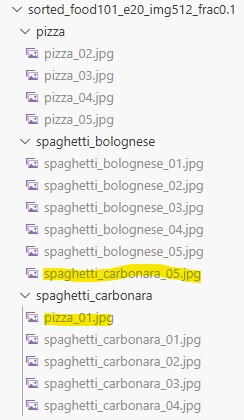




### food101_e50_img224_frac0.1: the most efficient with accuracy of `91.73%`
1/15 image are classified incorrectly:

![](notebooks/img/sorted_food101_e20_img512_frac0.1.jpg)


![](../runs/classify/sorted_food101_e50_img224_frac0.1/spaghetti_carbonara/pizza_05.jpg)

### food101_e50_img224_frac1: best accuracy of `97.60%`
1/15 image are classified incorrectly:

![](img/sorted_food101_e50_img224_frac0.1.jpg)
![](img/sorted_food101_e50_img224_frac1.jpg)
![](../runs/classify/sorted_food101_e50_img224_frac1/spaghetti_bolognese/spaghetti_carbonara_05.jpg)

### food101_e20_img512_frac0.1: lowest accuracy of `89.47%`
2/15 images are classified incorrectly:

![](img/sorted_food101_e20_img512_frac0.1.jpg)
![](../runs/classify/sorted_food101_e20_img512_frac0.1/spaghetti_bolognese/spaghetti_carbonara_05.jpg)
![](../runs/classify/sorted_food101_e20_img512_frac0.1/spaghetti_carbonara/pizza_01.jpg)
